In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          646 non-null    object 
 1   Daily Confirmed                               646 non-null    int64  
 2   False Positives Found                         537 non-null    float64
 3   Cumulative Confirmed                          646 non-null    int64  
 4   Daily Discharged                              646 non-null    int64  
 5   Passed but not due to COVID                   646 non-null    int64  
 6   Cumulative Discharged                         646 non-null    int64  
 7   Discharged to Isolation                       646 non-null    int64  
 8   Still Hospitalised                            646 non-null    int64  
 9   Daily Deaths                                  646 non-null    int

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)
#sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               646 non-null    int64  
 1   False Positives Found                         646 non-null    float64
 2   Cumulative Confirmed                          646 non-null    int64  
 3   Daily Discharged                              646 non-null    int64  
 4   Passed but not due to COVID                   646 non-null    int64  
 5   Cumulative Discharged                         646 non-null    int64  
 6   Discharged to Isolation                       646 non-null    int64  
 7   Still Hospitalised                            646 non-null    int64  
 8   Daily Deaths                                  646 non-null    int64  
 9   Cumulative Deaths                             646 non-null    int

<AxesSubplot:>

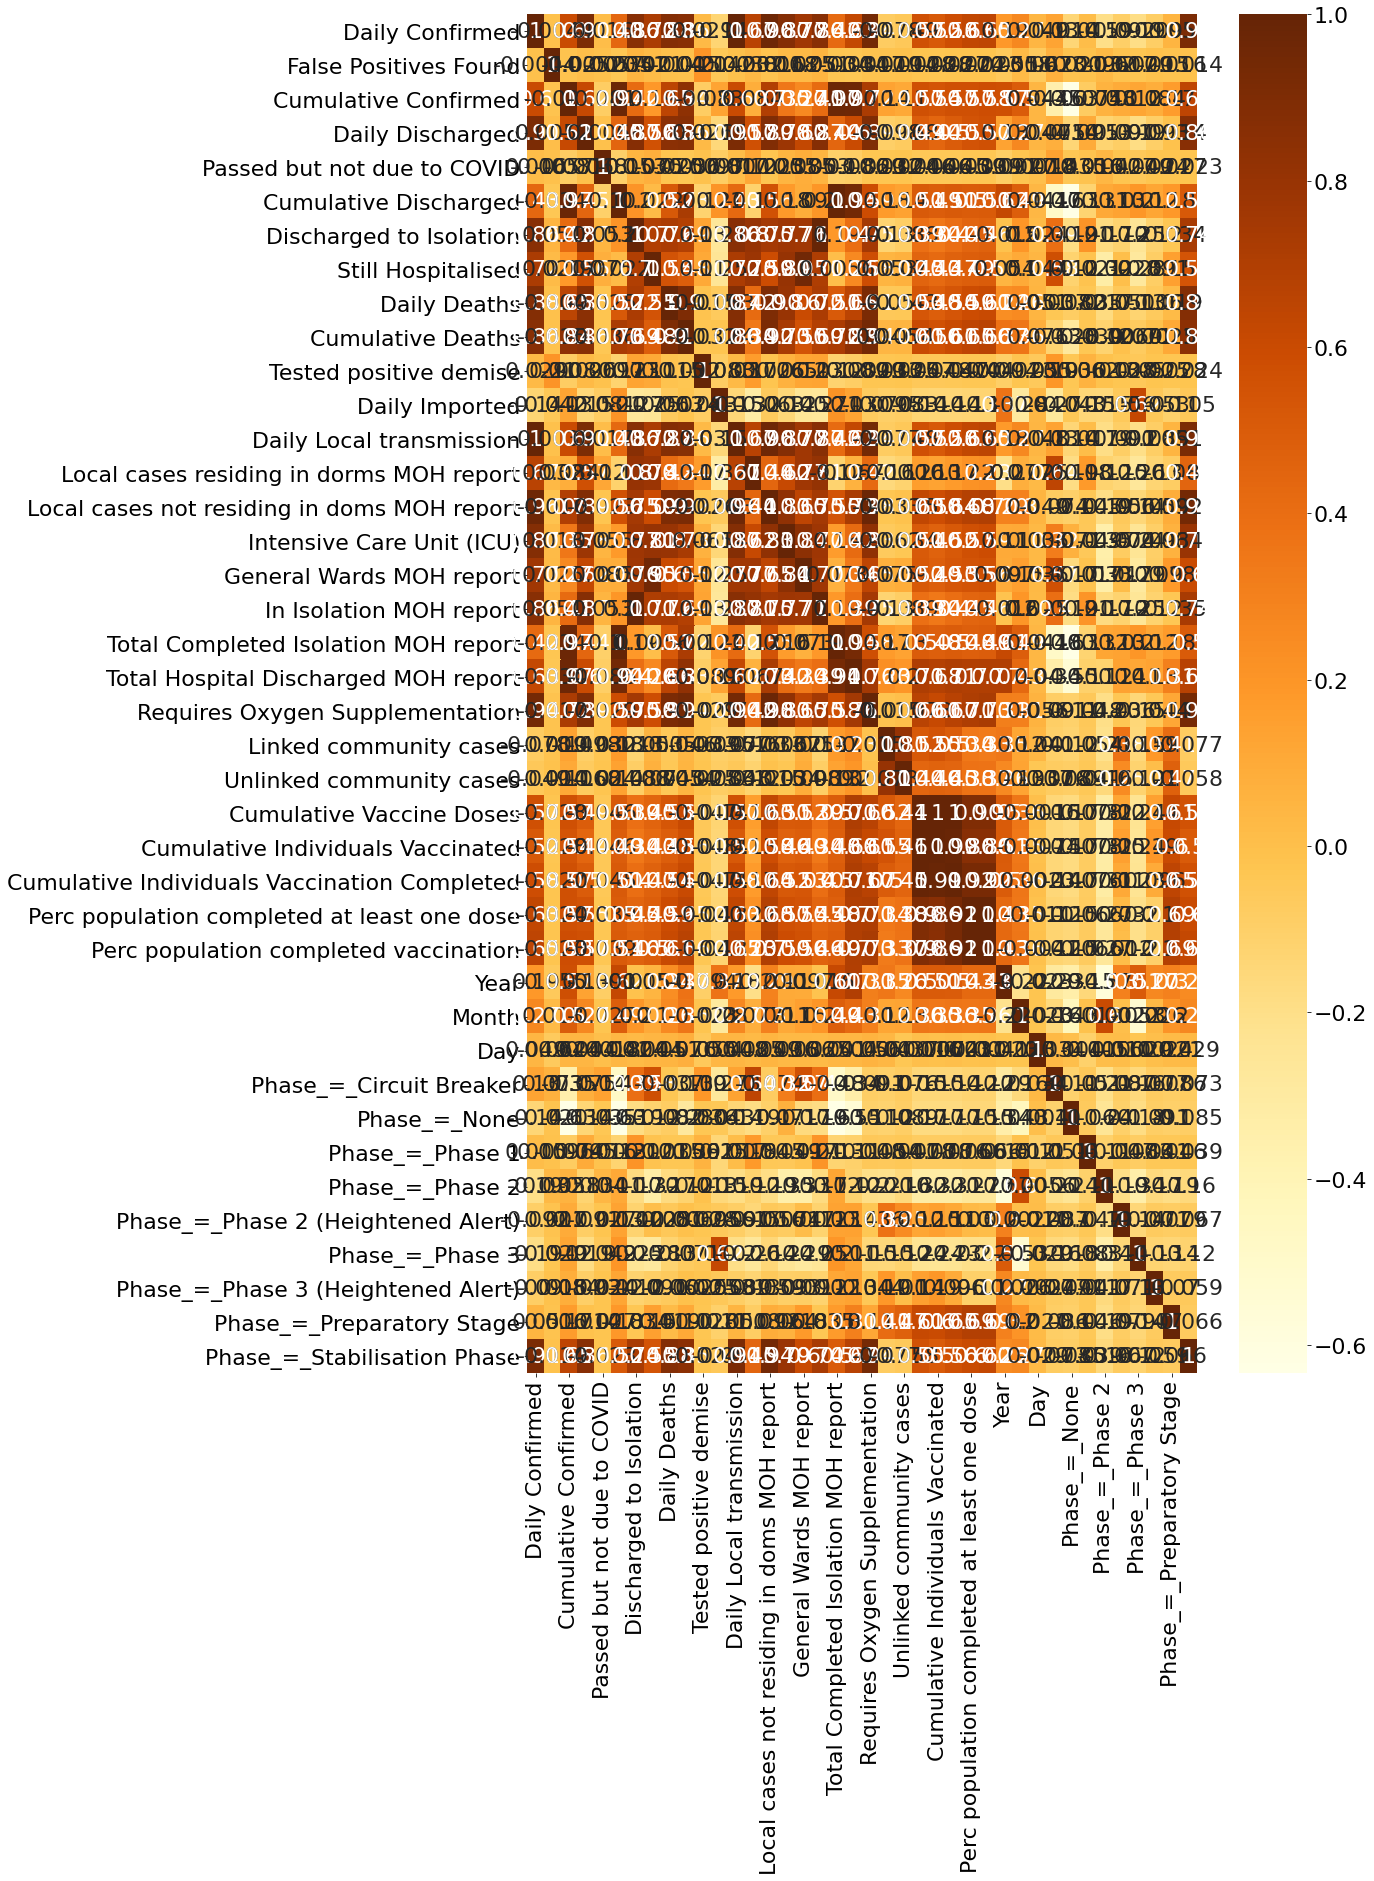

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Perc population completed vaccination"].sort_values(ascending=False)

Perc population completed vaccination           1.000000
Perc population completed at least one dose     0.998871
Cumulative Individuals Vaccination Completed    0.924918
Cumulative Vaccine Doses                        0.896336
Cumulative Individuals Vaccinated               0.859441
Requires Oxygen Supplementation                 0.726480
Total Hospital Discharged MOH report            0.704914
Local cases not residing in doms MOH report     0.700073
Phase_=_Preparatory Stage                       0.692838
Cumulative Deaths                               0.661749
Daily Local transmission                        0.649024
Daily Confirmed                                 0.648551
Phase_=_Stabilisation Phase                     0.617395
Daily Deaths                                    0.607102
Intensive Care Unit (ICU)                       0.585884
Cumulative Confirmed                            0.579115
Daily Discharged                                0.567627
General Wards MOH report       

# PCA

In [16]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [17]:
# pca.components_[0]

In [18]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [19]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Viewing Chart Pattern

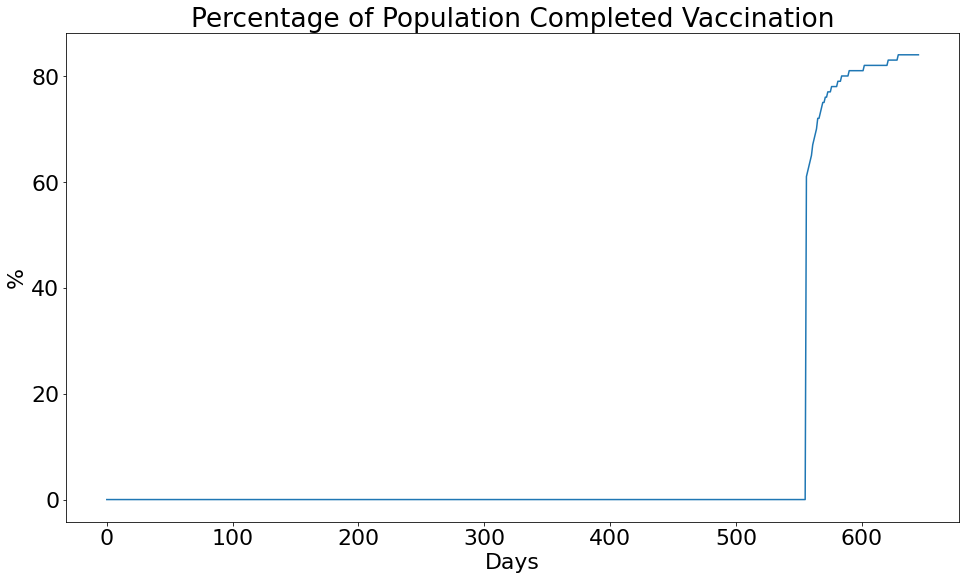

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Perc population completed vaccination"].plot()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()
fig.savefig('Percentage_of_Population_Completed_Vaccination.png')

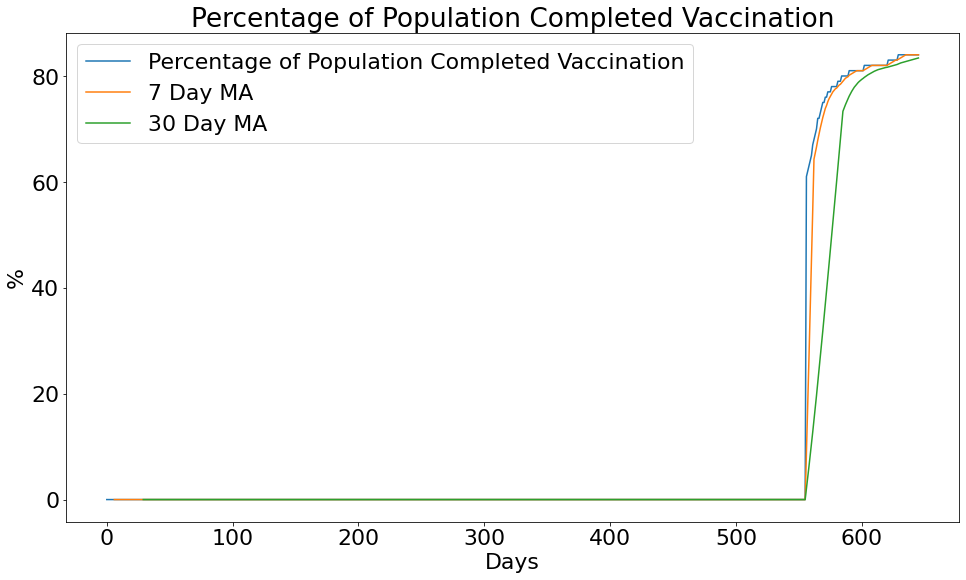

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Perc population completed vaccination"], label="Percentage of Population Completed Vaccination")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()
fig.savefig('Perc_population_completed_vaccination_with_moving_average.png')

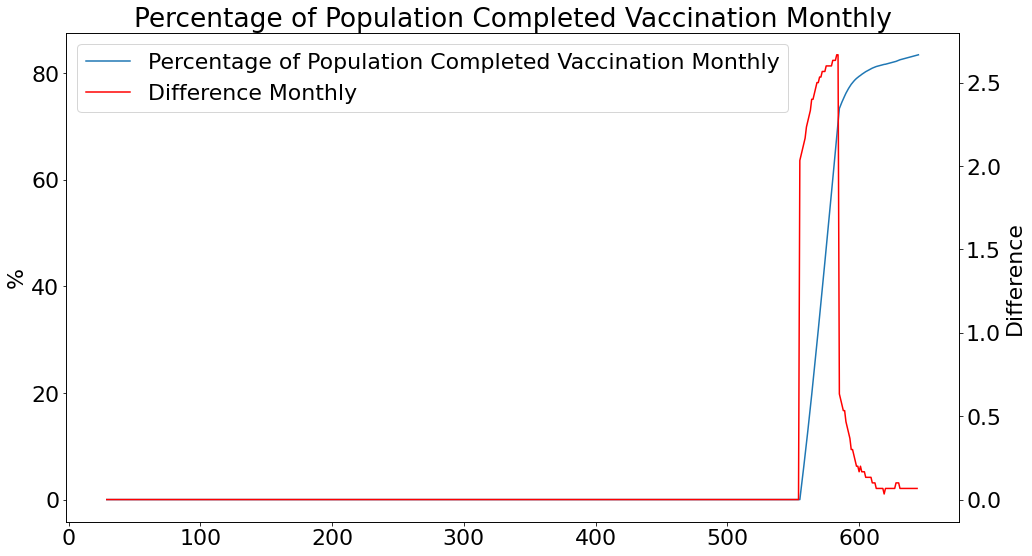

In [22]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="Percentage of Population Completed Vaccination Monthly")
ax.set_ylabel("%")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean()), label="Difference Monthly", color="red")
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1 + ln2)])
plt.title('Percentage of Population Completed Vaccination Monthly')
plt.xlabel('Days')
plt.show()
fig.savefig('Perc_population_completed_vaccination_with_diff.png')

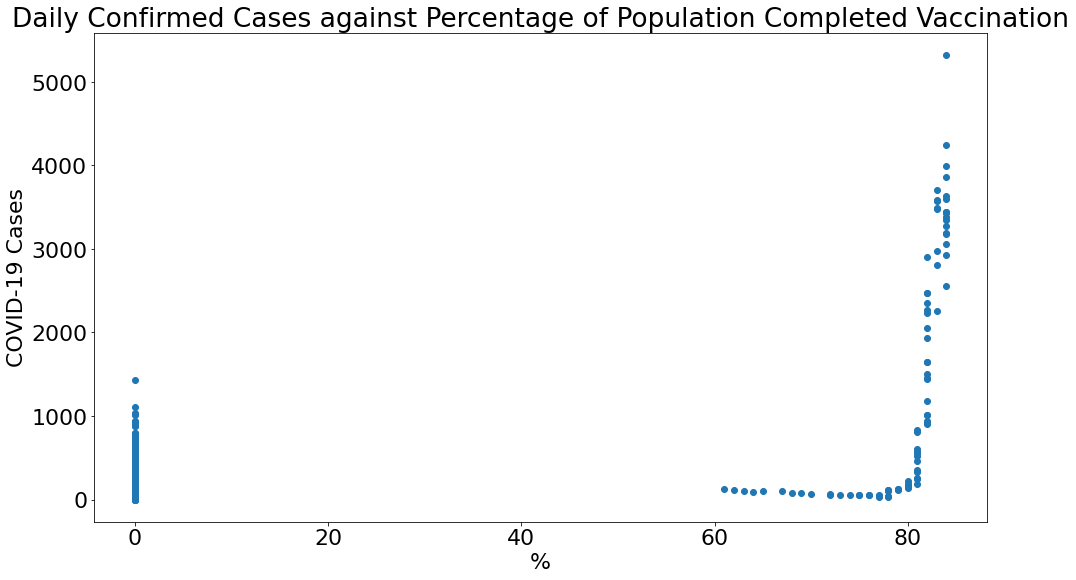

In [23]:
# Shall we use a constant rate of vaccination rate for the data we do not have? - imputation
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Perc population completed vaccination"],sg_data_filtered["Daily Confirmed"])
plt.title('Daily Confirmed Cases against Percentage of Population Completed Vaccination')
plt.xlabel('%')
plt.ylabel('COVID-19 Cases')
plt.show()
fig.savefig('Perc_population_completed_vaccination_scatter.png')

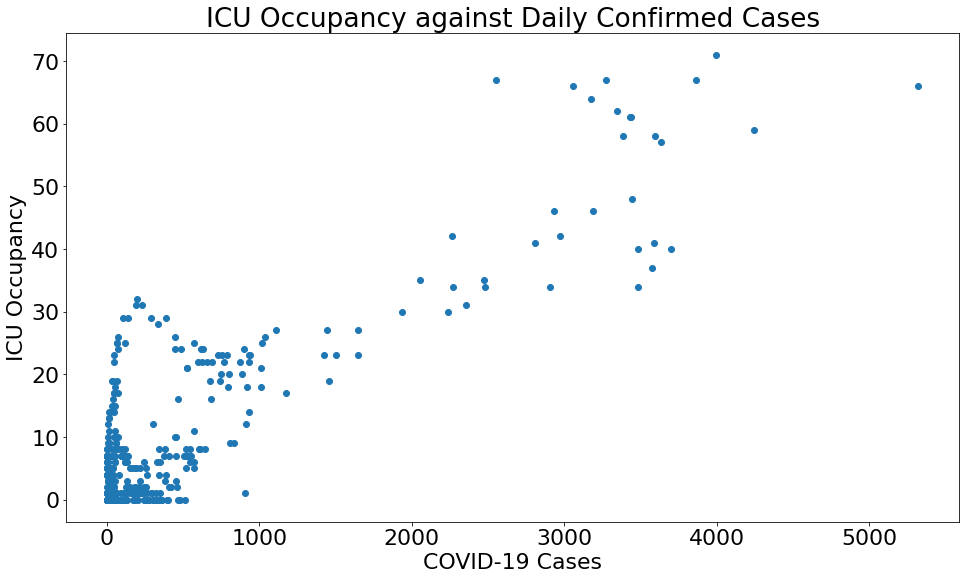

In [24]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Intensive Care Unit (ICU)"])
plt.title('ICU Occupancy against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('ICU Occupancy')
plt.show()
fig.savefig('ICU_Occupancy_against_Daily_Confirmed_Cases_Scatter.png')

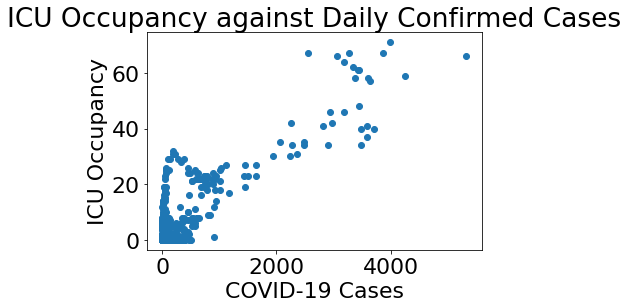

In [25]:

plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Intensive Care Unit (ICU)"])
plt.title('ICU Occupancy against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('ICU Occupancy')
plt.show()

## Phases

In [26]:
# fig, ax = plt.subplots(figsize=(16,9))
# sg_data_filtered.groupby('Phase')["Daily Confirmed"].mean().plot.bar()
# plt.title('Average COVID-19 Cases per Phase')
# plt.xlabel('Phases')
# plt.ylabel('Average COVID-19 Cases')
# plt.show()
# fig.savefig('Average_Cases_per_phase.png')

# Train Test Split & K Fold Cross Validation

In [27]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Perc population completed vaccination", axis=1)
y = sg_data_filtered["Perc population completed vaccination"]
y

0       0
1       0
2       0
3       0
4       0
       ..
641    84
642    84
643    84
644    84
645    84
Name: Perc population completed vaccination, Length: 646, dtype: int64

In [28]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [29]:
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [30]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [31]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for LR
MAE: 0.27699061897595884
MSE: 0.1756443249235524
RMSE: 0.41909942128754174
R-squared score for train: 0.9998215531633934
Adjusted R-squared score for train: 0.9998100689610375
R-squared score for test: 0.999739314161558
Adjusted R-squared score for test: 0.9997225373501731
Cross Validation Score: 0.9987


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


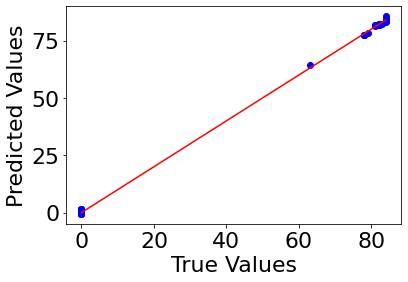

In [32]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

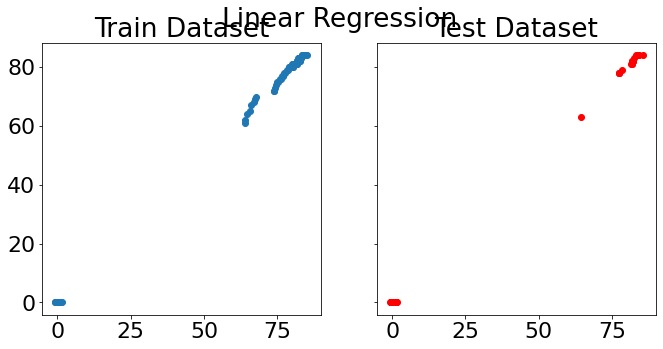

In [33]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [34]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,1.178320e+07
38,Phase_=_Stabilisation Phase,3.400356e+00
37,Phase_=_Preparatory Stage,3.176085e+00
26,Perc population completed at least one dose,8.056902e-01
10,Tested positive demise,2.277464e-01
6,Discharged to Isolation,1.855173e-01
7,Still Hospitalised,1.854771e-01
9,Cumulative Deaths,1.839825e-01
5,Cumulative Discharged,1.773052e-01
22,Unlinked community cases,1.714066e-02


# Ridge Regression

In [35]:
# build lasso model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.88443e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [36]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Ridge
MAE: 0.30327192234694905
MSE: 0.2807865079409402
RMSE: 0.5298929212028975
R-squared score for train: 0.9997751264003545
Adjusted R-squared score for train: 0.999760654337011
R-squared score for test: 0.9995832654070798
Adjusted R-squared score for test: 0.99955644585407
Cross Validation Score: 0.9976


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.65078e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.3406e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.1075e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.43951e-17)

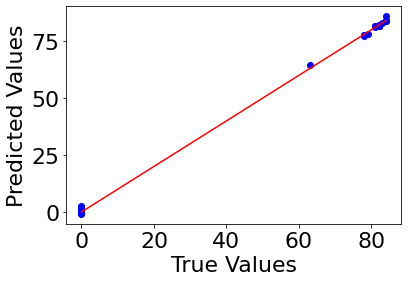

In [37]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

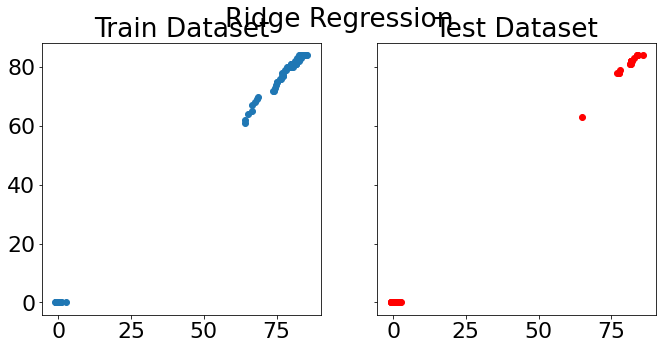

In [38]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [39]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
37,Phase_=_Preparatory Stage,2.095032
38,Phase_=_Stabilisation Phase,1.783695
26,Perc population completed at least one dose,0.792117
10,Tested positive demise,0.140332
9,Cumulative Deaths,0.139389
6,Discharged to Isolation,0.123639
7,Still Hospitalised,0.123587
5,Cumulative Discharged,0.117726
31,Phase_=_None,0.072165
22,Unlinked community cases,0.021450


# Ridge Regression Important Features & Future Prediction

In [40]:
# taking out the important features based on the importance level mentioned above as well as necessary features (e.g. Year Day Month)
# add in all the phases
important_X_train = X_train[["Perc population completed at least one dose","Cumulative Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Perc population completed at least one dose","Cumulative Confirmed","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()


In [41]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [42]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Ridge
MAE: 0.24309853128440645
MSE: 0.2418524977195308
RMSE: 0.49178501168654054
R-squared score for train: 0.9993747741585979
Adjusted R-squared score for train: 0.999334536851973
R-squared score for test: 0.9996410500528569
Adjusted R-squared score for test: 0.9996179493136843
Cross Validation Score: 0.9976


C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.65078e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.3406e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.1075e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\zeph1\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.43951e-17)

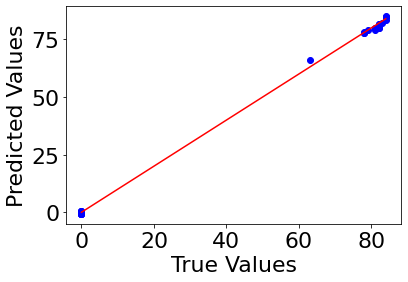

In [43]:
# For test set

# scatter for predictions
plt.scatter(y_test, impt_ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

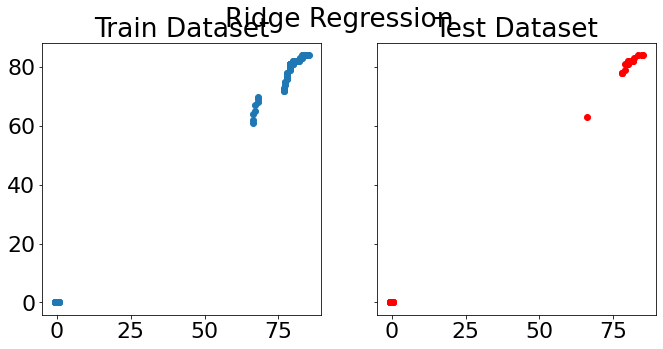

In [44]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(impt_ridge.predict(important_X_train), y_train)
ax[1].scatter(impt_ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [47]:
# cumulative confirmed should use the number of cases to predict if possible
future_prediction = pd.DataFrame(data={
    "Phase_=_Preparatory Stage":[0],
    "Perc population completed at least one dose":[90],
    "Cumulative Confirmed": [200000],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

impt_ridge_fut_pred = impt_ridge.predict(future_prediction)


In [48]:
impt_ridge_fut_pred
# predicted vaccination rate on 14 Dec 2021 is 88.7%

array([89.78337157])